## Agregação por distrito

Nesse notebook é feita a agregação dos dados por distritos do município

In [1]:
import geopandas as gpd
import random
from shapely.geometry import LineString
from utils.save_shp import save_shp
from utils.load_csv import load_csv
from utils.load_shp import load_shp

In [2]:
gdf_final = load_csv("gdf_final.csv")

distritos = load_shp("distritos.shp")

In [3]:
gdf_final["lon"] = gdf_final["ponto_inicial"].apply(lambda x: eval(x)[0])
gdf_final["lat"] = gdf_final["ponto_inicial"].apply(lambda x: eval(x)[1])

In [4]:
gdf_final = gpd.GeoDataFrame(gdf_final, geometry=gpd.points_from_xy(gdf_final.lon, gdf_final.lat), crs="EPSG:31983")

In [5]:
gdf_final.head()

,id_onibus,linha,is_eletrico,distancia_percorrida,ponto_inicial,ponto_final,momento_inicial,momento_final,modelo,litro_diesel_km,emissao_no2,emissao_co2,lon,lat,geometry
0,68853,5010-10,False,148.349719,"[332687.68579879985, 7383667.184539581]","[np.float64(332792.2284083655), np.float64(738...",2025-10-02 12:48:43-03:00,2025-10-02 12:49:30-03:00,Articulado (18m),0.8,3.281178,9.989606,332687.685799,7.383667e+06,POINT (332687.686 7383667.185)
1,68853,5010-10,False,32.385046,"[332792.2284083655, 7383772.438907389]","[np.float64(332804.84353484295), np.float64(73...",2025-10-02 12:49:30-03:00,2025-10-02 12:50:12-03:00,Articulado (18m),0.8,0.716288,2.180751,332792.228408,7.383772e+06,POINT (332792.228 7383772.439)
2,68853,5010-10,False,0.000000,"[332804.84353484295, 7383802.265905192]","[np.float64(332804.84353484295), np.float64(73...",2025-10-02 12:50:12-03:00,2025-10-02 12:50:12-03:00,Articulado (18m),0.8,0.000000,0.000000,332804.843535,7.383802e+06,POINT (332804.844 7383802.266)
3,68853,5010-10,False,87.364702,"[332804.84353484295, 7383802.265905192]","[np.float64(332744.1297509116), np.float64(738...",2025-10-02 12:50:12-03:00,2025-10-02 12:51:22-03:00,Articulado (18m),0.8,1.932320,5.882984,332804.843535,7.383802e+06,POINT (332804.844 7383802.266)
4,68853,5010-10,False,51.326566,"[332744.1297509116, 7383865.086503765]","[np.float64(332692.8276940262), np.float64(738...",2025-10-02 12:51:22-03:00,2025-10-02 12:51:41-03:00,Articulado (18m),0.8,1.135234,3.456240,332744.129751,7.383865e+06,POINT (332744.13 7383865.087)


In [6]:
dropar = gdf_final['id_onibus'].value_counts()[(gdf_final['id_onibus'].value_counts() == 1)].index

gdf_final = gdf_final[~gdf_final['id_onibus'].isin(dropar)].reset_index(drop=True)

In [7]:
trajetos = gdf_final.groupby("id_onibus")["geometry"].apply(lambda x: LineString(x.tolist()))
trajetos = gpd.GeoDataFrame(trajetos, geometry="geometry", crs="EPSG:31983").reset_index()

In [8]:
trajetos.head()

,id_onibus,geometry
0,3106,"LINESTRING (345990.634 7394759.92, 345990.634 ..."
1,3117,"LINESTRING (353148.717 7385509.566, 339982.012..."
2,7316,"LINESTRING (317964.902 7374418.635, 317964.902..."
3,10001,"LINESTRING (325312.768 7401503.714, 325312.768..."
4,10002,"LINESTRING (326163.361 7398113.136, 326163.361..."


In [9]:
agregados = gdf_final.groupby("id_onibus").agg({
    "emissao_co2": "sum",
    'is_eletrico': 'first'      
}).reset_index()

trajetos = trajetos.merge(agregados, on="id_onibus", how="left")

In [10]:
trajetos

,id_onibus,geometry,emissao_co2,is_eletrico
0,3106,"LINESTRING (345990.634 7394759.92, 345990.634 ...",6.902973,False
1,3117,"LINESTRING (353148.717 7385509.566, 339982.012...",965.013549,False
2,7316,"LINESTRING (317964.902 7374418.635, 317964.902...",2.293523,False
3,10001,"LINESTRING (325312.768 7401503.714, 325312.768...",56.005896,False
4,10002,"LINESTRING (326163.361 7398113.136, 326163.361...",37.671399,False
...,...,...,...,...
10069,86606,"LINESTRING (323657.501 7386449.749, 323657.501...",0.000000,True
10070,86608,"LINESTRING (327973.208 7391370.012, 327900.856...",38.022216,True
10071,86609,"LINESTRING (325620.589 7388981.247, 325668.089...",82.590079,True
10072,86610,"LINESTRING (323943.268 7386616.959, 323943.268...",164.206250,True


<Axes: >

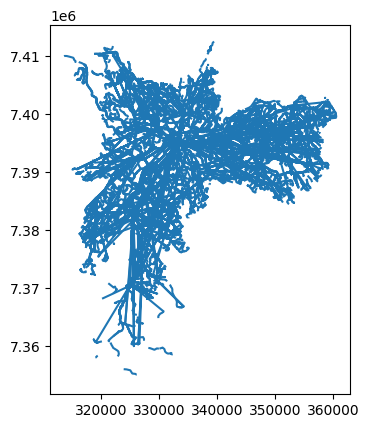

In [11]:
trajetos.plot()

35716


<Axes: >

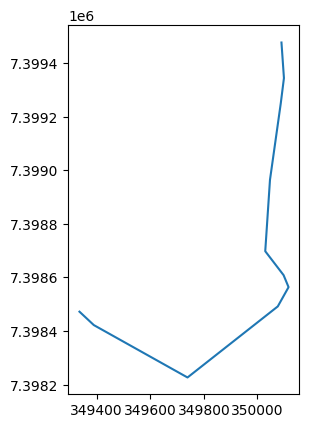

In [12]:
onibus_aleatorio = random.choice(trajetos['id_onibus'].unique().tolist())

print(onibus_aleatorio)
trajetos[trajetos['id_onibus'] == onibus_aleatorio].plot()

C:\Users\x050258\AppData\Local\Temp\ipykernel_62756\1219825511.py:1: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  trajetos[trajetos['id_onibus'] == 41101].plot()


<Axes: >

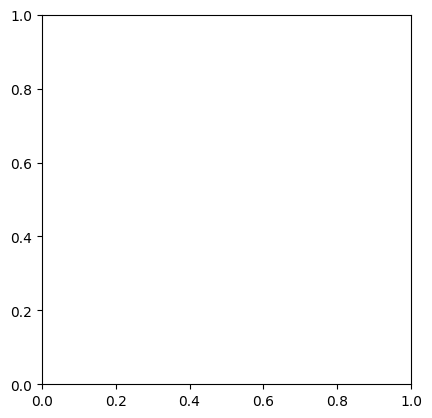

In [13]:
trajetos[trajetos['id_onibus'] == 41101].plot()

In [14]:
trajetos = trajetos.to_crs(distritos.crs)

In [15]:
trajetos_distritos = gpd.sjoin(trajetos, distritos, how="inner", predicate="intersects")

trajetos_distritos

,id_onibus,geometry,emissao_co2,is_eletrico,index_right,cd_identif,cd_identi0,cd_distrit,nm_distrit,sg_distrit,tx_escala,sg_fonte_o,dt_criacao,dt_atualiz,cd_usuario,cd_tipo_di,qt_area_qu,qt_area_me
0,3106,"LINESTRING (345990.634 7394759.92, 345990.634 ...",6.902973,False,82,8583464.0,27.0,24,CIDADE LIDER,CLD,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,10.356,10356058.83
1,3117,"LINESTRING (353148.717 7385509.566, 339982.012...",965.013549,False,47,8583429.0,26.0,85,VILA FORMOSA,VFO,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,7.473,7473222.27
1,3117,"LINESTRING (353148.717 7385509.566, 339982.012...",965.013549,False,67,8583419.0,30.0,75,SAO RAFAEL,SRA,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,13.076,13076288.46
1,3117,"LINESTRING (353148.717 7385509.566, 339982.012...",965.013549,False,25,8583420.0,32.0,76,SAPOPEMBA,SAP,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,13.633,13632901.77
1,3117,"LINESTRING (353148.717 7385509.566, 339982.012...",965.013549,False,43,8583417.0,30.0,73,SAO MATEUS,SMT,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,12.800,12800219.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10073,90999,"LINESTRING (347109.9 7401050.127, 348304.058 7...",2468.384485,False,71,8583445.0,21.0,5,ARTUR ALVIM,AAL,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,6.506,6505750.23
10073,90999,"LINESTRING (347109.9 7401050.127, 348304.058 7...",2468.384485,False,61,8583402.0,21.0,59,PENHA,PEN,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,11.429,11428502.95
10073,90999,"LINESTRING (347109.9 7401050.127, 348304.058 7...",2468.384485,False,41,8583407.0,22.0,64,PONTE RASA,PRA,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,6.597,6596680.61
10073,90999,"LINESTRING (347109.9 7401050.127, 348304.058 7...",2468.384485,False,30,8583458.0,21.0,18,CANGAIBA,CNG,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,13.746,13746396.83


In [16]:
gdf_overlay = gpd.overlay(trajetos, distritos, how="intersection")

gdf_overlay['distancia'] = gdf_overlay.geometry.length

gdf_overlay

,id_onibus,emissao_co2,is_eletrico,cd_identif,cd_identi0,cd_distrit,nm_distrit,sg_distrit,tx_escala,sg_fonte_o,dt_criacao,dt_atualiz,cd_usuario,cd_tipo_di,qt_area_qu,qt_area_me,geometry,distancia
0,3106,6.902973,False,8583464.0,27.0,24,CIDADE LIDER,CLD,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,10.356,10356058.83,"MULTILINESTRING ((345990.634 7394759.92, 34602...",66.289445
1,3117,965.013549,False,8583420.0,32.0,76,SAPOPEMBA,SAP,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,13.633,13632901.77,"MULTILINESTRING ((347423.675 7389607.4, 347253...",223.806687
2,3117,965.013549,False,8583417.0,30.0,73,SAO MATEUS,SMT,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,12.800,12800219.28,"MULTILINESTRING ((350506.219 7387400.996, 3474...",10452.956146
3,3117,965.013549,False,8583424.0,25.0,80,TATUAPE,TAT,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,8.514,8514313.05,"LINESTRING (341149.206 7394098.499, 339982.012...",2929.079977
4,3117,965.013549,False,8583429.0,26.0,85,VILA FORMOSA,VFO,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,7.473,7473222.27,"MULTILINESTRING ((343631.382 7392321.823, 3411...",6043.576590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13881,90999,2468.384485,False,8583444.0,26.0,4,ARICANDUVA,ARI,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,6.960,6959771.69,"LINESTRING (344805.977 7393908.946, 344173.133...",2182.197306
13882,90999,2468.384485,False,8583402.0,21.0,59,PENHA,PEN,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,11.429,11428502.95,"MULTILINESTRING ((347591.953 7397655.787, 3477...",2810.271760
13883,90999,2468.384485,False,8583435.0,21.0,91,VILA MATILDE,VMT,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,8.769,8769104.22,"LINESTRING (345830.414 7397289.64, 344983.38 7...",2920.771988
13884,90999,2468.384485,False,8583445.0,21.0,5,ARTUR ALVIM,AAL,1:5000,GEOGSG,2004-01-01,2025-07-05,None,199299399,6.506,6505750.23,"MULTILINESTRING ((347727.842 7396698.937, 3480...",4654.722469


In [17]:
gdf_distrito = gdf_overlay.groupby('nm_distrit').agg({
    'distancia':'sum',
    "emissao_co2": 'sum',
    'is_eletrico': 'first'
}).reset_index()

In [18]:
import warnings
warnings.filterwarnings("ignore", category = FutureWarning)

distritos = distritos.merge(gdf_distrito, on='nm_distrit', how='left')
distritos_final = distritos.fillna(0)

In [19]:
warnings.filterwarnings("ignore", category = RuntimeWarning)
warnings.filterwarnings("ignore", category = UserWarning)

save_shp(distritos_final, "distritos_final.shp")

Shapefile salvo em data\distritos_final.shp
